## How does concentration change near the head?

In [1]:
import cmocean as cmo
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.gridspec as gspec
import numpy as np
import seaborn as sns
import scipy.stats
import pandas as pd

import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg

import os
import sys
import warnings
warnings.filterwarnings("ignore")

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
grid_file1 = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run01/gridGlob.nc'
state_file2 = '/data/kramosmu/results/TracerExperiments/3DVISC_REALISTIC/run01/stateGlob.nc'

with Dataset(grid_file1, 'r') as nbl:
    Z1 = nbl.variables['RC'][:]
    hfac = nbl.variables['HFacC'][:,:,:]
    X = nbl.variables['X'][:]
    Y = nbl.variables['Y'][:]
with Dataset(state_file2,'r') as stfl:
    time = stfl.variables['T'][:]

mask = rout.getMask(grid_file1,'HFacC')    
nx = 616
ny = 360
nz = 90

In [3]:
# Information for all runs is stored in canyon_records.py
lib_path = os.path.abspath('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/PythonScripts/Paper1Figures/') # Add absolute path to my python scripts
sys.path.append(lib_path)

import canyon_records 

records = canyon_records.main()

In [4]:
# Indices of all runs that will be consdered for paper 1

select_rec = [0,1,2,3,4,5,6,7,8,9,16,17,18,19,20,
              21,22,23,24,25,26,27,28,29,30,31,32,
              33,34,37,38,40,41,42,43,44,45,46,47,48]

# records_dyn has all the runs without the ones where K_bg changes. Use these ones for fitting the data HA2013
ind = [0,3,4,5,6,7,8,9,16,17,18,19,20,21]
records_dyn = []
for ii in ind:
    records_dyn.append(records[ii])

# records_step has all the runs in records_dyn plus the step runs (use these to fit Phi with Nmean)
ind = [0,3,4,5,6,7,8,9,16,17,18,19,20,21,37,38,44,45,46,47,48]
records_step = []
for ii in ind:
    records_step.append(records[ii])

# records_epsilon has all the runs in records_step plus the epsilon runs (use these to fit Nmax+Nmin)
ind = [0,3,4,5,6,7,8,9,16,17,18,19,20,21,28,29,30,31,32,
              33,34,37,38,40,41,42,43,44,45,46,47,48]
records_epsilon = []
for ii in ind:
    records_epsilon.append(records[ii])

# records_diffusivity has all the runs with step and epsilon kv profiles; it does not have the dynamics runs
ind = [28,29,30,31,32,33,34,37,38,40,41,42,43,44,45,46,47,48]
records_diffusivity = []
for ii in ind:
    records_diffusivity.append(records[ii])

    
# records_kv has the runs with step kv profile
ind = [28,32,37,38,44,45,46,47,48] 

records_kv = []
for ii in ind:
    records_kv.append(records[ii])

# records_nokv has the runs without step kv profile
ind = [0,1,2,3,4,5,6,7,8,9,16,17,18,19,20,21,22,23,24,25,26,27,29,30,31,33,34,40,41,42,43]
       
records_nokv = []
for ii in ind:
    records_nokv.append(records[ii])

# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,6,7,8,9,16,17,18,19,21]
records3 = []
for ii in ind:
    records3.append(records[ii])



In [5]:
keys2 = ['dTrdz_tt16','dTrdz_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
    Nbe = 0
    Nrim = 0 
    Nmean = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab = Nab + np.min(df[keys2[ii]][0:20]) #0:20
        Nbe = Nbe + np.max(df[keys2[ii]][20:24]) #20:24
        Nmean = Nmean + np.mean(df[keys2[ii]][20:24])
        Nrim = Nrim + df[keys2[ii]][24]
    records[ind].dTr_ab = Nab/  len(keys2)
    records[ind].dTr_be = Nbe/  len(keys2)
    records[ind].dTr0 = df['dTrdz_tt00'][15]

In [6]:
keys2 = ['Tr_profile_tt16','Tr_profile_tt18']
stname = 'UwH' # Station at downstream head side of canyon

for ind in select_rec:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    Nab = 0
          
    for key,ii in zip(keys2, range(len(keys2))):
        Nab = Nab + np.mean(df[keys2[ii]][12:24]) #0:20
        
    records[ind].Tr =  Nab /  len(keys2)
    
stname = 'DnC' 
for ind in select_rec:
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' %
                 (records[ind].name,stname))
    df = pd.read_csv(filename1)
    records[ind].Tr0 = df['Tr_profile_tt00'][29]

### Tracer gradient and concentration

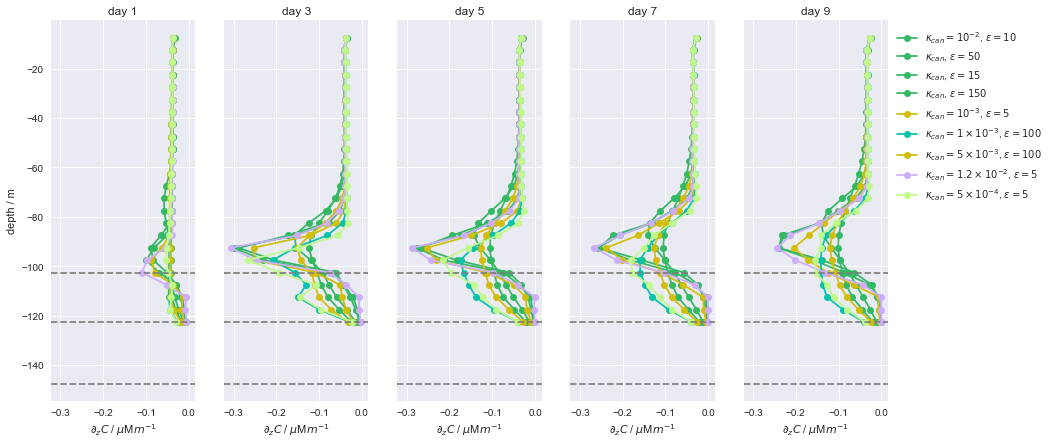

In [28]:
# Tracer gradient

keys = ['dTrdz_tt02','dTrdz_tt06','dTrdz_tt10','dTrdz_tt14','dTrdz_tt18']
days = ['1','3','5','7','9']
sns.set_style('darkgrid')

stname = 'UwH' # Station at downstream side of canyon

fig, ax = plt.subplots(1,len(keys),figsize=(15,7), sharey = True, sharex = True)

for rec in records_diffusivity[::2]:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s_%s.csv' %
                 (rec.exp_code,rec.run_num,stname))
    df = pd.read_csv(filename1)
    
    for key,ii,day in zip(keys, range(len(keys)), days):
        ax[ii].plot(df[keys[ii]][:],Z1[1:-1],'-o' ,color= sns.xkcd_rgb[rec.color2], label = rec.label)  
        ax[ii].set_title('day %s' %day)


for ii in range(len(keys)):
    ax[ii].set_xlabel('$\partial_zC$ / $\mu$M$m^{-1}$')
    ax[ii].axhline(Z1[20],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[24],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[29],color = '0.5', linestyle = '--') # rim depth


ax[0].set_ylabel('depth / m')
ax[len(keys)-1].legend(bbox_to_anchor=(1,1))    
    


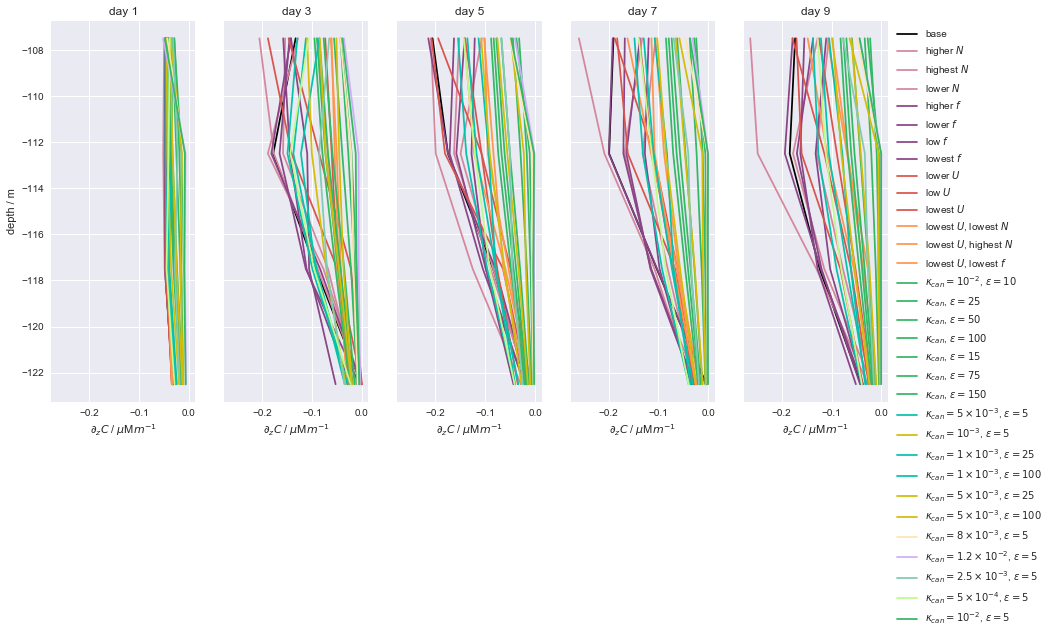

In [22]:
# Tracer gradient

keys = ['dTrdz_tt02','dTrdz_tt06','dTrdz_tt10','dTrdz_tt14','dTrdz_tt18']
days = ['1','3','5','7','9']
sns.set_style('darkgrid')

stname = 'UwH' # Station at downstream side of canyon

fig, ax = plt.subplots(1,len(keys),figsize=(15,7), sharey = True, sharex = True)

for rec in records_epsilon:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s_%s.csv' %
                 (rec.exp_code,rec.run_num,stname))
    df = pd.read_csv(filename1)
    
    for key,ii,day in zip(keys, range(len(keys)), days):
        ax[ii].plot(df[keys[ii]][20:32],Z1[21:33], color= sns.xkcd_rgb[rec.color2], label = rec.label)  
        ax[ii].set_title('day %s' %day)


for ii in range(len(keys)):
    ax[ii].set_xlabel('$\partial_zC$ / $\mu$M$m^{-1}$')

ax[0].set_ylabel('depth / m')
ax[len(keys)-1].legend(bbox_to_anchor=(1,1))    



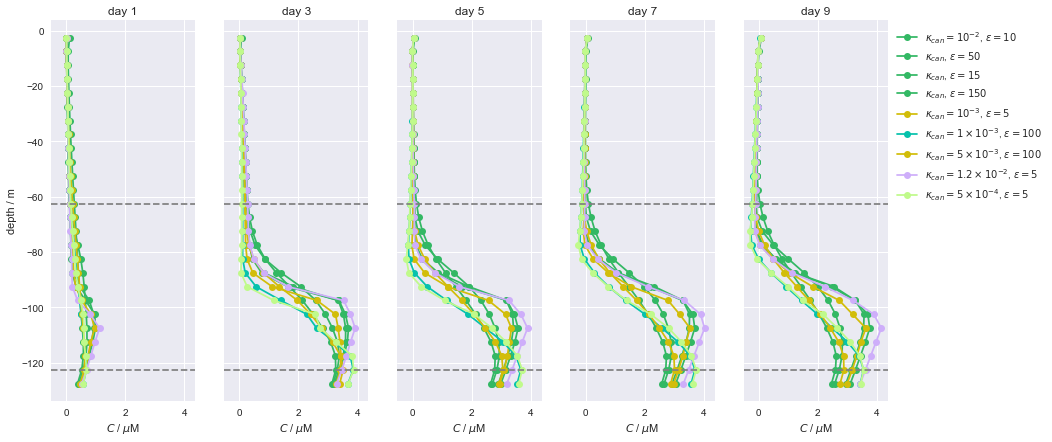

In [30]:
# Tracer profile
sns.set_style('darkgrid')

keys = ['Tr_profile_tt02','Tr_profile_tt06','Tr_profile_tt10','Tr_profile_tt14','Tr_profile_tt18']
days = ['1','3','5','7','9']

stname = 'UwH' # Station at downstream side of canyon

fig, ax = plt.subplots(1,len(keys),figsize=(15,7), sharey = True, sharex = True)

for rec in records_diffusivity[::2]:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s_%s.csv' %
                 (rec.exp_code,rec.run_num,stname))
    df = pd.read_csv(filename1)
    Crim = 0
    for key,ii,day in zip(keys, range(len(keys)), days):
        ax[ii].plot(df[keys[ii]][:]-df['Tr_profile_tt00'][:],Z1[:],'o-', color= sns.xkcd_rgb[rec.color2], label = rec.label)  
        ax[ii].set_title('day %s' %day)
        Crim = Crim + df[keys[ii]][26]
    rec.Crim = Crim /  len(keys)

for ii in range(len(keys)):
    ax[ii].set_xlabel('$C$ / $\mu$M')
    ax[ii].axhline(Z1[12],color = '0.5', linestyle = '--') # rim depth
    ax[ii].axhline(Z1[24],color = '0.5', linestyle = '--') # rim depth

ax[0].set_ylabel('depth / m')
ax[len(keys)-1].legend(bbox_to_anchor=(1,1))    

#plt.savefig('tracerprofile_comparison_realisticKv.eps', format='eps', frameon=False, bbox='tight')